# **Warping**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [ ]:
if torch.cuda.is_available():
    print("GPU is available and being used.")
else:
    print("GPU is not available or not being used.")

from google.colab import drive
drive.mount('/content/gdrive/')

GPU is available and being used.
Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC

/content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Prepare data**

In [ ]:
data_dir = "data/"
splitted_train_data = pd.read_csv(data_dir + "train.csv", header=None)
splitted_valid_data = pd.read_csv(data_dir + "valid.csv", header=None)
splitted_test_data = pd.read_csv(data_dir + "test.csv", header=None)
num_train, num_valid, num_test = len(splitted_train_data), len(splitted_valid_data), len(splitted_test_data)
num_train, num_valid, num_test

(1600, 400, 4000)

In [ ]:
# random shuffle
random_seed = 3407
np.random.seed(random_seed)
_order_train = list(range(num_train))
_order_valid = list(range(num_valid))
_order_test = list(range(num_test))
np.random.shuffle(_order_train)
np.random.shuffle(_order_valid)
np.random.shuffle(_order_test)

splitted_train_data_np = splitted_train_data.values
splitted_valid_data_np = splitted_valid_data.values
splitted_test_data_np = splitted_test_data.values

raw_train_data = splitted_train_data_np[_order_train, :]
raw_valid_data = splitted_valid_data_np[_order_valid, :]
raw_test_data = splitted_test_data_np[_order_test, :]

# the last col is response variable
data_train = raw_train_data[:, :-1]
label_train = raw_train_data[:, [-1]]
data_valid = raw_valid_data[:, :-1]
label_valid = raw_valid_data[:, [-1]]
data_test = raw_test_data[:, :-1]
label_test = raw_test_data[:, [-1]]
print(data_train.shape, label_train.shape)
print(data_valid.shape, label_valid.shape)
print(data_test.shape, label_test.shape)

(1600, 1000) (1600, 1)
(400, 1000) (400, 1)
(4000, 1000) (4000, 1)


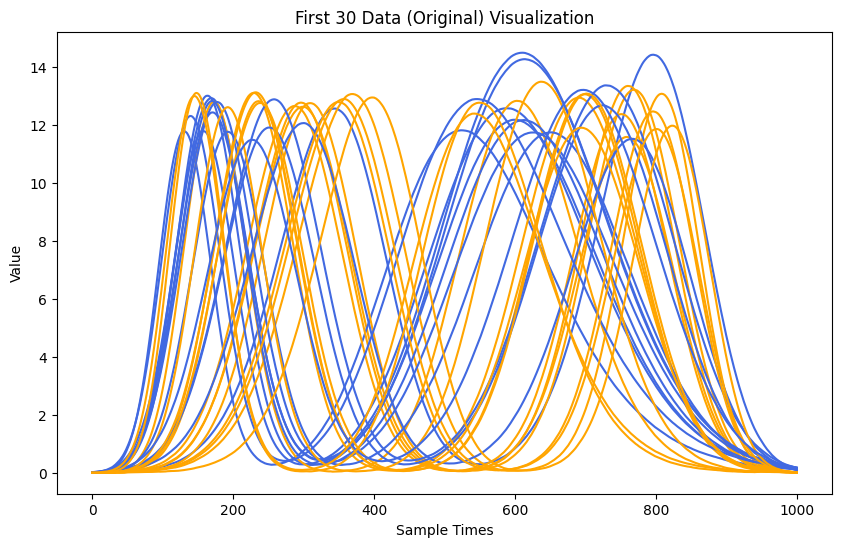

In [ ]:
data = np.concatenate((data_train, data_valid, data_test), axis=0)
label = np.concatenate((label_train, label_valid, label_test))

# Visualize
# plot each class in one color
num_samples = 30
shown_data = data[:num_samples]
seq_len= data.shape[1]
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(seq_len)
for i in range(num_samples):
    if label[i] == 1:
        plt.plot(shown_data[i], color='royalblue')
    else:
        plt.plot(shown_data[i], color='orange')
ax.set_xlabel('Sample Times')
ax.set_ylabel('Value')
plt.title(f'First {num_samples} Data (Original) Visualization')
# ax.legend()
plt.show()

Data is normalized...
torch.Size([1600, 1, 1001]) torch.Size([400, 1, 1001]) torch.Size([4000, 1, 1001])


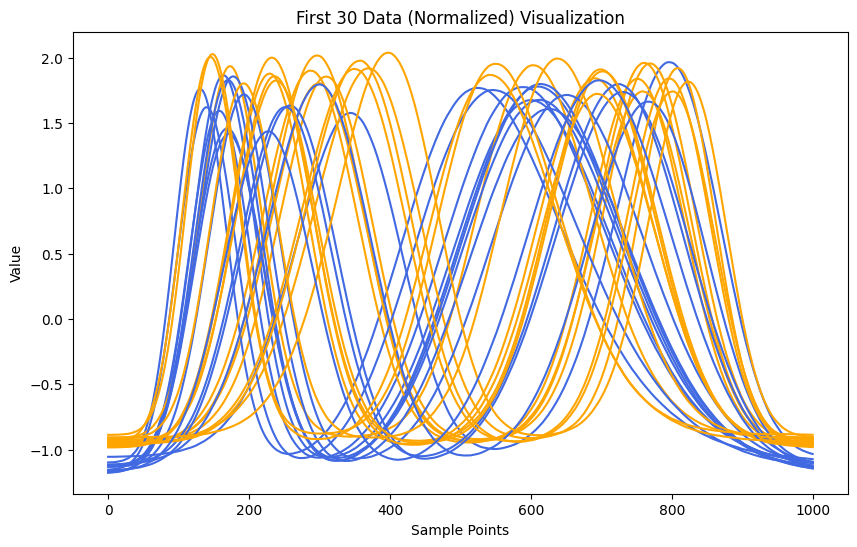

In [ ]:
# Normalize (through row direction)
def Normalization_on_data(input_f):
    '''
    input_f N,C=1,L : () torch.tensor
    Output N,C=1,L: After Z normalization
    '''
    length = input_f.size()[2]
    miu = torch.mean(input_f,dim=2).repeat(1,length).unsqueeze(1)
    input_f = input_f - miu
    sigma = input_f.std(dim=2,keepdim=True)
    input_f = input_f / sigma
    return input_f, miu, sigma

# backup raw data
train_n, valid_n = num_train, num_valid
raw_data_train, raw_data_valid, raw_data_test = data_train, data_valid, data_test
raw_label_train, raw_label_valid, raw_label_test = label_train, label_valid, label_test
# apply normalization
data = torch.from_numpy(data).unsqueeze(1)
norm_data, miu, sigma = Normalization_on_data(data)
# Sanity check
is_one = torch.isclose(norm_data.std(dim=2)[0][0], torch.tensor(1.0, dtype=norm_data.dtype), rtol=1e-05, atol=1e-08)
if not is_one:
    raise("ERROR in normalization, plz check!")
else:
    print("Data is normalized...")

# save miu & sigma
miu_train = miu[:train_n, :, :]
miu_valid = miu[train_n:(train_n+valid_n), :, :]
miu_test = miu[(train_n+valid_n):, :, :]
sigma_train = sigma[:train_n, :, :]
sigma_valid = sigma[train_n:(train_n+valid_n), :, :]
sigma_test = sigma[(train_n+valid_n):, :, :]
# print(f"miu_train: {miu_train.shape}\nmiu_valid: {miu_valid.shape}\nmiu_test: {miu_test.shape}")
# print(f"sigma_train: {sigma_train.shape}\nsigma_valid: {sigma_valid.shape}\nsigma_test: {sigma_test.shape}")

# Visualize normalized data
norm_data_train = norm_data[:train_n, :]
norm_data_valid = norm_data[train_n:(train_n+valid_n), :]
norm_data_test = norm_data[(train_n+valid_n):, :]
label_train = torch.as_tensor(raw_label_train).unsqueeze(1)
label_valid = torch.as_tensor(raw_label_valid).unsqueeze(1)
label_test = torch.as_tensor(raw_label_test).unsqueeze(1)
processed_data_train = torch.cat((norm_data_train, label_train), 2)
processed_data_valid = torch.cat((norm_data_valid, label_valid), 2)
processed_data_test = torch.cat((norm_data_test, label_test), 2)
processed_data_train = processed_data_train.float().to(device)
processed_data_test = processed_data_test.float().to(device)
processed_data_valid = processed_data_valid.float().to(device)
print(processed_data_train.shape, processed_data_valid.shape, processed_data_test.shape)

processed_data = torch.cat((processed_data_train, processed_data_valid, processed_data_test), 0)
processed_label = processed_data.squeeze(1)[:, -1]

shown_data_normed = processed_data[:num_samples].cpu().numpy()
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(seq_len)
for i in range(num_samples):
    if label[i] == 1:
        plt.plot(shown_data_normed[i, 0, :-1], color='royalblue')
    else:
        plt.plot(shown_data_normed[i, 0, :-1], color='orange')
ax.set_xlabel('Sample Points')
ax.set_ylabel('Value')
plt.title(f'First {num_samples} Data (Normalized) Visualization')
# ax.legend()
plt.show()

In [ ]:
print("Train：", processed_data_train.shape)
print("Val：", processed_data_valid.shape)
print("Test：", processed_data_test.shape)

Train： torch.Size([1600, 1, 1001])
Val： torch.Size([400, 1, 1001])
Test： torch.Size([4000, 1, 1001])


In [ ]:
# remove label
data_train_nolabel = processed_data_train[:, :, :-1].squeeze(1)
data_valid_nolabel = processed_data_valid[:, :, :-1].squeeze(1)
data_test_nolabel  = processed_data_test[:, :, :-1].squeeze(1)

data_train_nolabel = data_train_nolabel.clone().detach().requires_grad_(True)
data_valid_nolabel = data_valid_nolabel.clone().detach().requires_grad_(True)
data_test_nolabel  = data_test_nolabel.clone().detach().requires_grad_(True)

print("Train no label:", data_train_nolabel.shape)
print("Valid no label:", data_valid_nolabel.shape)
print("Test  no label:", data_test_nolabel.shape)

Train no label: torch.Size([1600, 1000])
Valid no label: torch.Size([400, 1000])
Test  no label: torch.Size([4000, 1000])


In [ ]:
x = torch.linspace(0, 1, 1000).to(device)
y_misaligned_train = data_train_nolabel
y_misaligned_valid = data_valid_nolabel
y_misaligned_test = data_test_nolabel

In [ ]:
print(x.device)
print(y_misaligned_train.device)
print(y_misaligned_valid.device)
print(y_misaligned_test.device)

cuda:0
cuda:0
cuda:0
cuda:0


## **Simulation Data**

In [ ]:
num_curves = 3000 # num of curves for each class
seq_len = 1000 # datapoints

In [ ]:
# Create a figure for plotting
plt.figure(figsize=(8, 6))
# Create an array of x values
x = np.linspace(0, seq_len, seq_len)
# 2 peaks scenario
# base functions b1 & b2 (where each is a single peak function)
p_r_b1 = 60
p_r_b2 = 75
# for b1
# Randomly choose a location for the peak of the Gaussian curve
peak_location_b1 = 250
# Randomly choose the width of the peak, which affects how "fat" or "thin" the peak is
peak_range_b1 = p_r_b1
# Randomly choose the height of the peak
peak_height_b1 = 13

# for b2
peak_location_b2 = 715
peak_range_b2 = p_r_b2
peak_height_b2 = 12.5
"""
# for b3
peak_location_b3 = 800
peak_range_b3 = 10
peak_height_b3 = 1.12
"""
# type 1
y_type1_b1 = peak_height_b1 * np.exp(-0.5 * ((x - peak_location_b1) ** 2) / peak_range_b1 ** 2)
y_type1_b2 = peak_height_b2 * np.exp(-0.5 * ((x - peak_location_b2) ** 2) / peak_range_b2 ** 2)
# y_type1_b3 = peak_height_b3 * np.exp(-0.5 * ((x - peak_location_b3) ** 2) / peak_range_b3 ** 2)
y_type1 = y_type1_b1 + y_type1_b2

<Figure size 800x600 with 0 Axes>

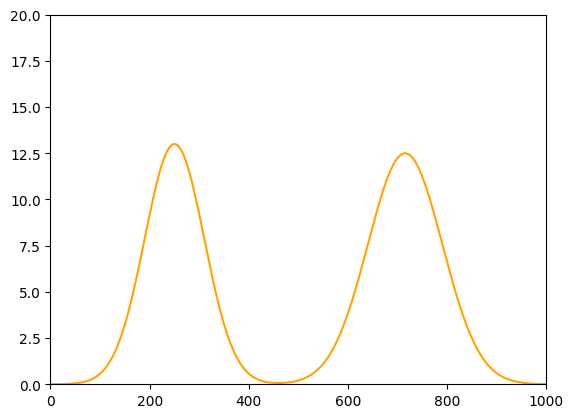

In [ ]:
plt.plot(x, y_type1, color='orange')
plt.xlim(0, seq_len)
plt.ylim(-0, 20)
plt.show()

In [ ]:
y_template = torch.tensor(y_type1, dtype=torch.float32).view(1, -1)
y_template.shape

torch.Size([1, 1000])

In [ ]:
data_A = np.zeros((num_curves, seq_len))
data_A[0, :] = y_type1
# for the rest "num_curves-1"
# we add small noises on range and height to simulate small difference between individuals
for i in range(1, num_curves):
    peak_location_b1i = peak_location_b1 # fixed
    peak_range_b1i = peak_range_b1 + random.randint(-2, 2)
    peak_height_b1i = peak_height_b1 + random.uniform(-0.5, 0.5)

    peak_location_b2i = peak_location_b2 # fixed
    peak_range_b2i = peak_range_b2 + random.randint(-3, 3)
    peak_height_b2i = peak_height_b2 + random.uniform(-1, 1)

    y_b1i = peak_height_b1i * np.exp(-0.5 * ((x - peak_location_b1i) ** 2) / peak_range_b1i ** 2)
    y_b2i = peak_height_b2i * np.exp(-0.5 * ((x - peak_location_b2i) ** 2) / peak_range_b2i ** 2)

    y_i = y_b1i + y_b2i

    data_A[i, :] = y_i
# data_A.shape (3000，1000)

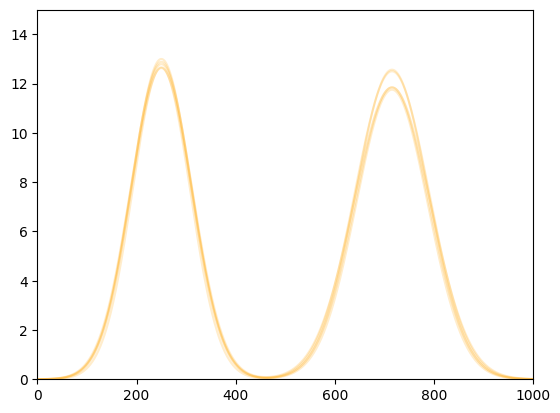

In [ ]:
for i in range(5):
    plt.plot(x, data_A[i, :], 'orange', alpha=0.2)
plt.xlim(0, seq_len)
plt.ylim(0, 15)
plt.show()

In [ ]:
y_misaligned = torch.tensor(data_A, dtype=torch.float32) #.view(1,-1)
y_misaligned.shape

#y_template = y_template.expand(green_line.size(0), -1)

torch.Size([3000, 1000])

In [ ]:
y_misaligned[0:1].shape

torch.Size([1, 1000])

In [ ]:
x = torch.linspace(0, 1, 1000)

## **SRVF**

In [ ]:
def compute_srvf_normalized(x, y, epsilon=1e-6):
    dy_dx = torch.gradient(y, spacing=(x,), dim=(-1))[0]
    q = dy_dx / torch.sqrt(torch.abs(dy_dx) + epsilon)
    L2_norm = torch.sqrt(torch.trapezoid(q**2, x, dim=-1) + epsilon).unsqueeze(-1)
    q_normalized = q / L2_norm

    return q_normalized

### **Template SRVF**

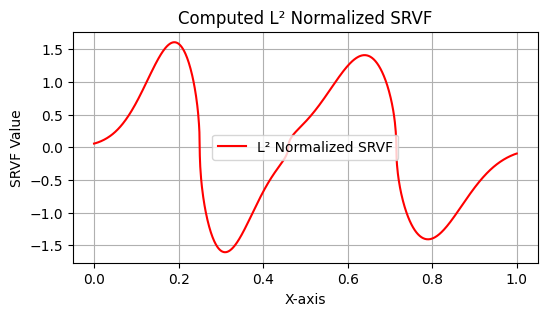

In [ ]:
# input to fisher rao loss
q_srvf_template = compute_srvf_normalized(x, y_template)

plt.figure(figsize=(6, 3))
plt.plot(x, q_srvf_template.view(-1), label="L² Normalized SRVF", color='r')
plt.xlabel("X-axis")
plt.ylabel("SRVF Value")
plt.title("Computed L² Normalized SRVF")
plt.legend()
plt.grid()
plt.show()

In [ ]:
q_srvf_template.shape

NameError: name 'q_srvf_template' is not defined

### **Unaligned SRVF**

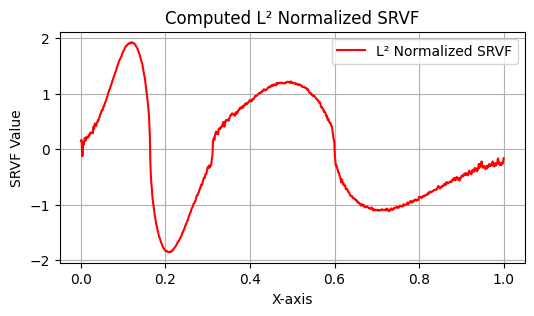

In [ ]:
# input to VAE forward function
q_srvf_unaligned = compute_srvf_normalized(x, y_misaligned_train)

plt.figure(figsize=(6, 3))
plt.plot(
    x.cpu().detach().numpy(),
    q_srvf_unaligned[1:2].view(-1).cpu().detach().numpy(),
    label="L² Normalized SRVF",
    color='r'
)
plt.xlabel("X-axis")
plt.ylabel("SRVF Value")
plt.title("Computed L² Normalized SRVF")
plt.legend()
plt.grid()
plt.show()

## **VAE**

### VAE easy

In [ ]:
class VAE_easy(nn.Module):
    def __init__(self, input_dim=100, latent_dim=10):
        super(VAE_easy, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Tanh()  # [-1,1]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def hadamard_normalization(self, v_theta, epsilon=1e-6):
        gamma_dot = v_theta * v_theta + epsilon # >=0

        # Ensure gamma_dot has at least 2 dimensions
        if gamma_dot.dim() == 1:
            gamma_dot = gamma_dot.unsqueeze(0)

        # cumsum
        gamma_theta = torch.cumsum(gamma_dot, dim=1)
        # [0,1]
        start = gamma_theta[:, :1]
        end   = gamma_theta[:, -1:]
        end   = torch.where(end<epsilon, epsilon, end)
        gamma_theta = (gamma_theta - start) / (end - start)
        return gamma_theta, gamma_dot

    def forward(self, x):
        # Encoder
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decoder => v_theta => gamma_theta
        v_theta = self.decoder(z)  # (batch, 100)
        # print("v_theta shape: ", v_theta.shape)
        gamma_theta, gama_dot_theta = self.hadamard_normalization(v_theta)

        return mu, log_var, gamma_theta, gama_dot_theta

### VAE normal

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=100, latent_dim=16):
        super(VAE_easy, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
        )

        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            # nn.Sigmoid()
            nn.Tanh() #[-1,1]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def hadamard_normalization(self, v_theta, epsilon = 1e-6):
        norm_v = torch.norm(v_theta, dim=1, keepdim=True)
        norm_v = torch.where(norm_v < epsilon, epsilon, norm_v)

        v_theta = v_theta / norm_v # v_theta / ||v_theta||
        # print(v_theta)

        # non-negative
        gamma_dot_theta = v_theta * v_theta

        # γ(0) = 0
        gamma_theta = torch.cumsum(gamma_dot_theta, dim=1)

        # γ(1) = 1
        gamma_theta = gamma_theta - gamma_theta[:, :1]  # start at 0
        gamma_theta = gamma_theta / gamma_theta[:, -1].unsqueeze(1)  # end at 1

        return gamma_dot_theta, gamma_theta

    def forward(self, x):
        hidden = self.encoder(x)
        mu = self.mu(hidden)
        log_var = self.log_var(hidden)

        z = self.reparameterize(mu, log_var)
        v_theta = self.decoder(z)

        # diffeomorphism
        gamma_dot_theta, gamma_theta = self.hadamard_normalization(v_theta)

        return gamma_theta, mu, log_var, gamma_dot_theta

### VAE improve

In [ ]:
class VAE_high(nn.Module):
    def __init__(self, input_dim=1000, latent_dim=32):
        super(VAE_high, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 528),
            nn.BatchNorm1d(528),
            nn.ReLU(),
            nn.Linear(528, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.65),
        )
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 528),
            nn.BatchNorm1d(528),
            nn.ReLU(),
            nn.Linear(528, input_dim),
            nn.Tanh()  # [-1,1]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def hadamard_normalization(self, v_theta, epsilon=1e-6):
        gamma_dot = v_theta * v_theta + epsilon # >=0

        # Ensure gamma_dot has at least 2 dimensions
        if gamma_dot.dim() == 1:
            gamma_dot = gamma_dot.unsqueeze(0)

        # cumsum
        gamma_theta = torch.cumsum(gamma_dot, dim=1)
        # [0,1]
        start = gamma_theta[:, :1]
        end   = gamma_theta[:, -1:]
        end   = torch.where(end<epsilon, epsilon, end)
        gamma_theta = (gamma_theta - start) / (end - start)
        return gamma_theta, gamma_dot

    def forward(self, x):
        # Encoder
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)

        # Reparameterize
        z = self.reparameterize(mu, log_var)

        # Decoder => v_theta => gamma_theta
        v_theta = self.decoder(z)  # (batch, 100)
        # print("v_theta shape: ", v_theta.shape)
        #print("v_theta mean:", v_theta.mean().item())
        #print("v_theta std:", v_theta.std().item())
        #print("v_theta min:", v_theta.min().item())
        #print("v_theta max:", v_theta.max().item())
        gamma_theta, gama_dot_theta = self.hadamard_normalization(v_theta)

        return mu, log_var, gamma_theta, gama_dot_theta

## **linear interp**

In [ ]:
def linear_interp(signal, gamma):
    # signal.shape will return a tuple with the size of each dimension.
    # If signal is 1D, it will have a single element.
    # If signal is 2D, it will have two elements representing batch size and signal length.
    if len(signal.shape) == 1:
        N = signal.shape[0]  # Get the signal length for the 1D case
        real_idx = gamma * (N - 1)  # Calculate real index based on gamma
        idx_floor = real_idx.floor().long()  # Get the floor index
        idx_ceil = torch.clamp(idx_floor + 1, max=N - 1)  # Get the ceiling index
        alpha = real_idx - idx_floor.float()  # Calculate interpolation weight

        # Gather signal values using indices and perform linear interpolation
        s_floor = signal[idx_floor]
        s_ceil = signal[idx_ceil]
        out = s_floor + (s_ceil - s_floor) * alpha
        return out
    elif len(signal.shape) == 2:  # Assuming 2D for the current case
        B, N = signal.shape  # Unpack batch size (B) and signal length (N)
        real_idx = gamma * (N - 1)  # Calculate real index based on gamma
        idx_floor = real_idx.floor().long()  # Get the floor index
        idx_ceil = torch.clamp(idx_floor + 1, max=N - 1)  # Get the ceiling index
        alpha = real_idx - idx_floor.float()  # Calculate interpolation weight

        # Gather signal values using indices and perform linear interpolation
        s_floor = torch.gather(signal, dim=1, index=idx_floor)
        s_ceil = torch.gather(signal, dim=1, index=idx_ceil)
        out = s_floor + (s_ceil - s_floor) * alpha
        return out
    else:
        raise ValueError("signal must be 1D or 2D")

## **Loss**

In [ ]:
def compute_template(q, gamma_theta, gamma_dot_theta, epsilon=1e-6):
    # Warp each q_i
    q_warped = linear_interp(q, gamma_theta)  # (B, N)
    sqrt_gamma_dot = torch.sqrt(torch.clamp(gamma_dot_theta, min=epsilon))
    q_warped = q_warped * sqrt_gamma_dot

    # Average across batch
    q_mean = torch.mean(q_warped, dim=0)  # (N,)

    # Normalize to unit norm (Hilbert sphere constraint)
    q_hat = q_mean / (torch.norm(q_mean, p=2) + epsilon)
    return q_hat

### MSE

In [ ]:
def vae_loss(mu, log_var, gamma_theta, gamma_theta_dot, y_misaligned,
            lambda_kl=1.0,
            lambda_mse=1.0,
            lambda_smooth=1.0,
            lambda_curv=1.0,
            epsilon=1e-6):

    # KL Loss
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    # Warp input
    warped_y = linear_interp(y_misaligned, gamma_theta)  # (B, N)

    # Compute template from warped signals
    # y_template = torch.mean(warped_y, dim=0)  # (N,)
    y_template = torch.mean(warped_y, dim=0, keepdim=True) # (1, N)
    y_template = y_template.expand_as(warped_y)

    # MSE Loss
    # The MSE loss should be calculated between each warped sample and the template.
    # Broadcasting will handle this correctly if y_template has shape (1, N) and warped_y has shape (B, N).
    mse = F.mse_loss(warped_y, y_template)

    # Smoothness Loss
    # diff_1 = gamma_theta[:, 1:] - gamma_theta[:, :-1]
    # smooth_loss = torch.mean(diff_1.pow(2))

    diff_1 = gamma_theta[:, 1:] - gamma_theta[:, :-1]
    smooth_loss = torch.sum(diff_1.pow(2))  # ||γ̇||₂²

    # Curvature Loss
    # if diff_1.shape[-1] > 1:
    #   diff_2 = diff_1[:, 1:] - diff_1[:, :-1]
    #   curvature_loss = torch.mean(diff_2.pow(2))
    # else:
    #   curvature_loss = torch.tensor(0.0).to(diff_1.device)

    if diff_1.shape[-1] > 1:
        diff_2 = diff_1[:, 1:] - diff_1[:, :-1]
        curvature_loss = torch.sum(diff_2.pow(2))  # ||γ̈||₂²
    else:
        curvature_loss = torch.tensor(0.0).to(diff_1.device)


    # Total Loss
    total_loss = (lambda_kl * kl + lambda_mse * mse +
                  lambda_smooth * smooth_loss + lambda_curv * curvature_loss)

    return total_loss, mse, kl, smooth_loss, curvature_loss, warped_y, y_template

### Fisher Rao

In [ ]:
# vae + fisher rao
def fisher_rao_loss(q, gamma_theta, gamma_theta_dot, q_template):
    q_transformed = q * gamma_theta  # q ∘ γ^θ
    sqrt_term = torch.sqrt(torch.clamp(gamma_theta_dot * q_transformed, min=1e-6)) # sqrt(ẏ^θ)(q ∘ γ^θ)
    loss = torch.norm(q_template - sqrt_term
                      , p=2, dim=1).pow(2)  # q_template - sqrt(ẏ^θ)(q ∘ γ^θ)
    return loss.mean()

def vae_loss_fisher_rao(mu, log_var, gamma_theta, gamma_theta_dot, q, q_template):
    lambda_FR = 1
    lambda_grad = 500
    lambda_grad2 = 100
    lambda_KL = 100

    # Fisher-Rao: q_template - sqrt(ẏ^θ)(q ∘ γ^θ)
    fr_loss = fisher_rao_loss(q, gamma_theta, gamma_theta_dot, q_template)

    # KL divergence
    #kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    # Smoothness
    gamma_dot = torch.gradient(gamma_theta, dim=1)[0]
    smoothness_loss = torch.mean((gamma_dot[:, 1:] - gamma_dot[:, :-1]) ** 2)

    # Oscillation
    gamma_ddot = torch.gradient(gamma_dot, dim=1)[0]
    curvature_loss = torch.mean(gamma_ddot ** 2)

    # smoothness_loss /= torch.mean(torch.abs(gamma_theta))
    # curvature_loss /= torch.mean(torch.abs(gamma_dot))

    # sum of losses
    loss = (lambda_FR * fr_loss + lambda_KL * kl_loss +
            lambda_grad * smoothness_loss + lambda_grad2 * curvature_loss)
    return loss, fr_loss, kl_loss, smoothness_loss, curvature_loss

In [ ]:
def vae_loss_fisher_rao_with_template(mu, log_var, gamma_theta, gamma_theta_dot, q):
    lambda_FR = 1
    lambda_grad = 500
    lambda_grad2 = 100
    lambda_KL = 100

    q_template = compute_template(q, gamma_theta, gamma_theta_dot)

    # Fisher-Rao
    fr_loss = fisher_rao_loss(q, gamma_theta, gamma_theta_dot, q_template)

    # KL
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    # Smoothness
    diff_1 = gamma_theta[:, 1:] - gamma_theta[:, :-1]
    smoothness_loss = torch.mean(diff_1.pow(2))

    # Oscillation
    diff_2 = diff_1[:, 1:] - diff_1[:, :-1]
    curvature_loss = torch.mean(diff_2.pow(2))

    # sum of losses
    total_loss = (lambda_FR * fr_loss + lambda_KL * kl_loss +
                  lambda_grad * smoothness_loss + lambda_grad2 * curvature_loss)

    return total_loss, fr_loss, kl_loss, smoothness_loss, curvature_loss, q_template

## **Dataloader**

In [ ]:
#dataset = TensorDataset(y_misaligned)
# DataLoader
#batch_size = 128
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size

#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

batch_size = 64

train_dataset = TensorDataset(y_misaligned_train)
valid_dataset = TensorDataset(y_misaligned_valid)
test_dataset  = TensorDataset(y_misaligned_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **Training**

### MSE

In [ ]:
def train(model, dataloader, optimizer, num_epochs=100):
    model.train()

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        mse_epoch = 0.0
        kl_epoch = 0.0
        smooth_epoch = 0.0
        curv_epoch = 0.0

        for batch in dataloader:
            y = batch[0].to(device)  # (batch_size, 1000)

            # Forward
            mu, log_var, gamma_theta, gamma_theta_dot = model(y)
            plt.plot(gamma_theta[0].detach().cpu().numpy())

            # Loss
            loss, mse, kl, smooth, curv, y_warped, y_template = vae_loss(
                mu, log_var, gamma_theta, gamma_theta_dot, y,
                lambda_kl=0.5, lambda_mse=5,
                lambda_smooth=10, lambda_curv=10
            )

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss_epoch += loss.item()
            mse_epoch += mse.item()
            kl_epoch += kl.item()
            smooth_epoch += smooth.item()
            curv_epoch += curv.item()

        # avg loss
        avg_total_loss = total_loss_epoch / len(dataloader)
        avg_mse = mse_epoch / len(dataloader)
        avg_kl = kl_epoch / len(dataloader)
        avg_smooth = smooth_epoch / len(dataloader)
        avg_curv = curv_epoch / len(dataloader)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Total Loss: {avg_total_loss:.4f} | "
            f"MSE: {avg_mse:.4f} | "
            f"KL: {avg_kl:.4f} | "
            f"Smooth: {avg_smooth:.4f} | "
            f"Curvature: {avg_curv:.4f}"
        )

Epoch [1/50] | Total Loss: 6.5954 | MSE: 0.4247 | KL: 6.1801 | Smooth: 0.1000 | Curvature: 0.0382
Epoch [2/50] | Total Loss: 3.9381 | MSE: 0.2761 | KL: 3.2314 | Smooth: 0.0889 | Curvature: 0.0053
Epoch [3/50] | Total Loss: 3.4404 | MSE: 0.2532 | KL: 2.4185 | Smooth: 0.0920 | Curvature: 0.0045
Epoch [4/50] | Total Loss: 3.1351 | MSE: 0.2396 | KL: 1.9019 | Smooth: 0.0943 | Curvature: 0.0043
Epoch [5/50] | Total Loss: 2.9568 | MSE: 0.2313 | KL: 1.6396 | Smooth: 0.0939 | Curvature: 0.0041
Epoch [6/50] | Total Loss: 2.8463 | MSE: 0.2224 | KL: 1.5077 | Smooth: 0.0942 | Curvature: 0.0039
Epoch [7/50] | Total Loss: 2.8044 | MSE: 0.2269 | KL: 1.4021 | Smooth: 0.0931 | Curvature: 0.0038
Epoch [8/50] | Total Loss: 2.6789 | MSE: 0.2079 | KL: 1.3341 | Smooth: 0.0935 | Curvature: 0.0038
Epoch [9/50] | Total Loss: 2.6740 | MSE: 0.2192 | KL: 1.2315 | Smooth: 0.0928 | Curvature: 0.0034
Epoch [10/50] | Total Loss: 2.5929 | MSE: 0.2048 | KL: 1.2238 | Smooth: 0.0926 | Curvature: 0.0031
Epoch [11/50] | Tot

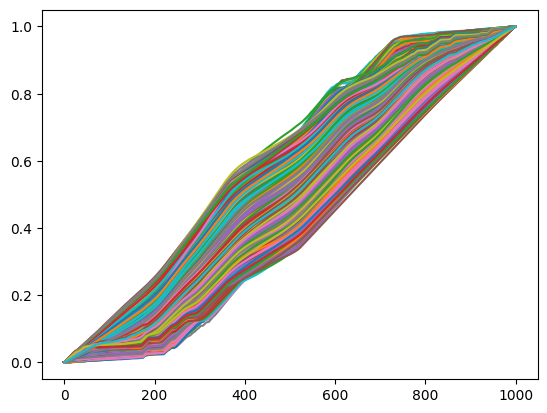

In [ ]:
# Initialize
vae = VAE_high(input_dim=1000, latent_dim=32).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 50
# Train
train(vae, train_loader, optimizer, num_epochs=num_epochs)

### **Draw warped signal**

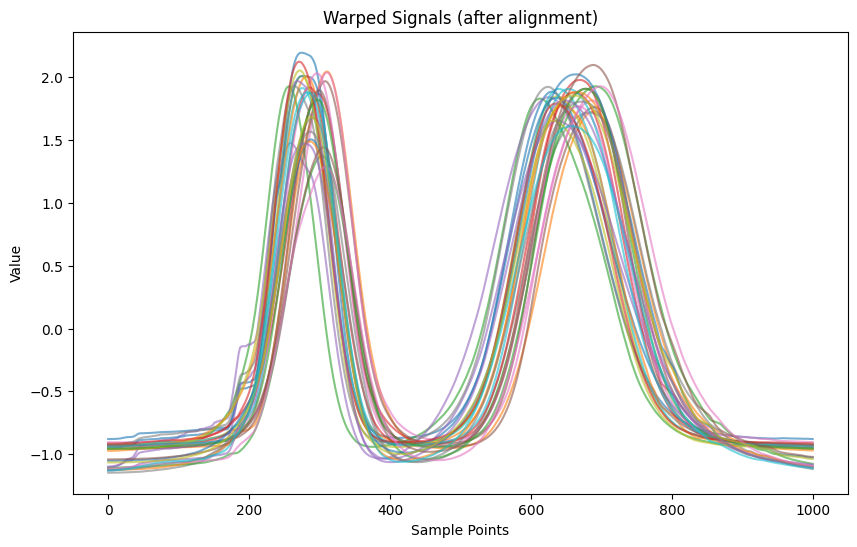

In [ ]:
vae.eval()
all_warped_y = []
all_gamma = []

with torch.no_grad():
    for batch in train_loader:
        y = batch[0].to(device)
        mu, log_var, gamma_theta, gamma_theta_dot = vae(y)

        warped_y = linear_interp(y, gamma_theta)
        all_warped_y.append(warped_y.cpu())
        all_gamma.append(gamma_theta.cpu())

all_warped_y = torch.cat(all_warped_y, dim=0)  # (N, 1000)
all_gamma = torch.cat(all_gamma, dim=0)        # (N, 1000)

# first 30
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for i in range(30):
    plt.plot(all_warped_y[i].numpy(), alpha=0.6)
plt.title('Warped Signals (after alignment)')
plt.xlabel('Sample Points')
plt.ylabel('Value')
plt.show()

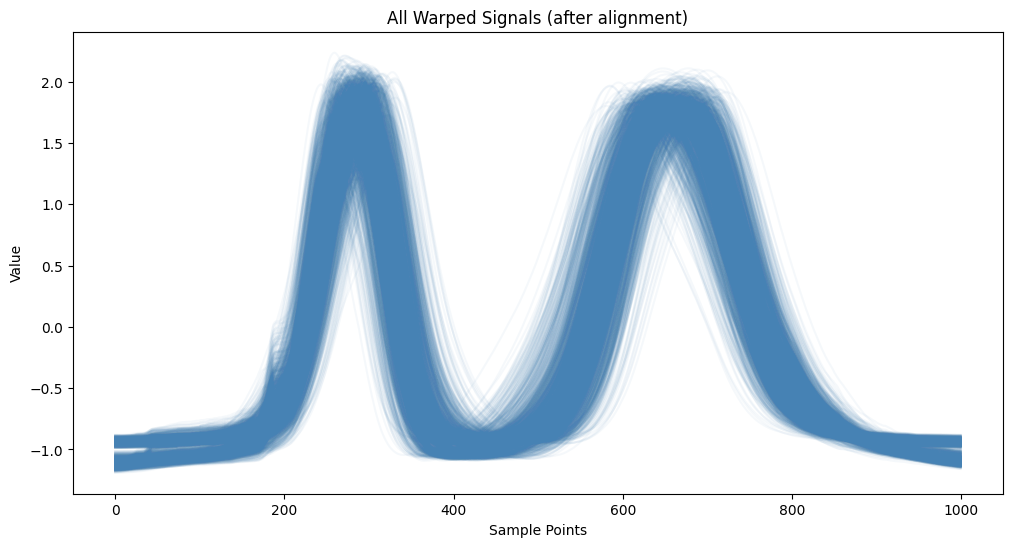

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(all_warped_y.shape[0]):
    plt.plot(all_warped_y[i].numpy(), color='steelblue', alpha=0.05)

plt.title('All Warped Signals (after alignment)')
plt.xlabel('Sample Points')
plt.ylabel('Value')
plt.show()

## **Test/Validation**

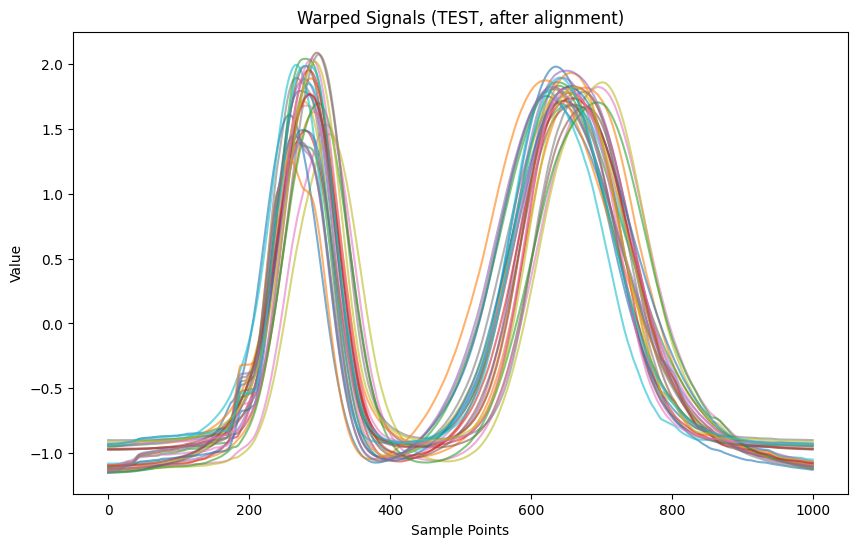

In [ ]:
vae.eval()
all_warped_y_test = []
all_gamma_test = []
with torch.no_grad():
    for batch in test_loader:
        y = batch[0].to(device)
        mu, log_var, gamma_theta, gamma_theta_dot = vae(y)
        warped_y = linear_interp(y, gamma_theta)
        all_warped_y_test.append(warped_y.cpu())
        all_gamma_test.append(gamma_theta.cpu())
all_warped_y_test = torch.cat(all_warped_y_test, dim=0)
all_gamma_test = torch.cat(all_gamma_test, dim=0)

# first 30 test
plt.figure(figsize=(10,6))
for i in range(30):
    plt.plot(all_warped_y_test[i].numpy(), alpha=0.6)
plt.title('Warped Signals (TEST, after alignment)')
plt.xlabel('Sample Points')
plt.ylabel('Value')
plt.show()

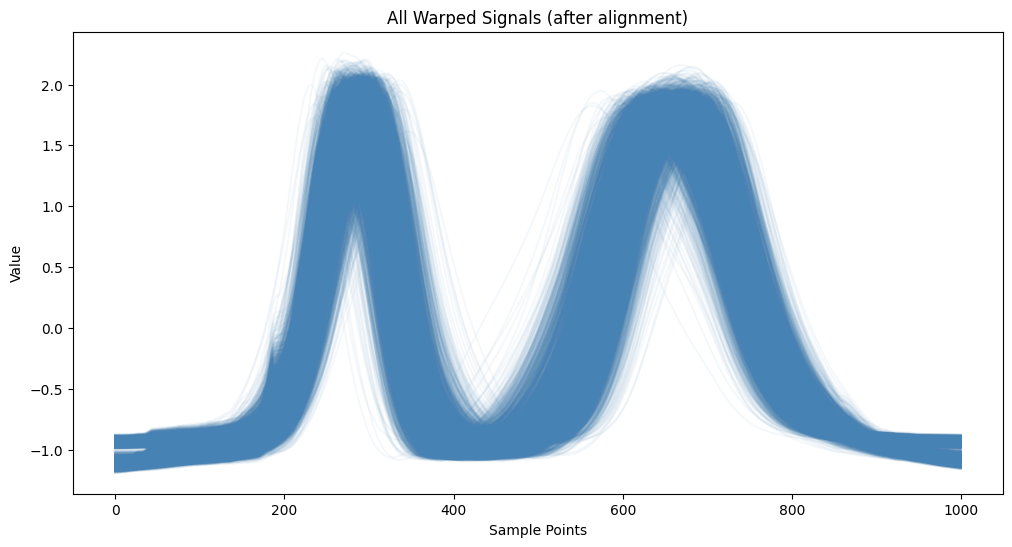

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(all_warped_y_test.shape[0]):
    plt.plot(all_warped_y_test[i].numpy(), color='steelblue', alpha=0.05)

plt.title('All Warped Signals (after alignment)')
plt.xlabel('Sample Points')
plt.ylabel('Value')
plt.show()

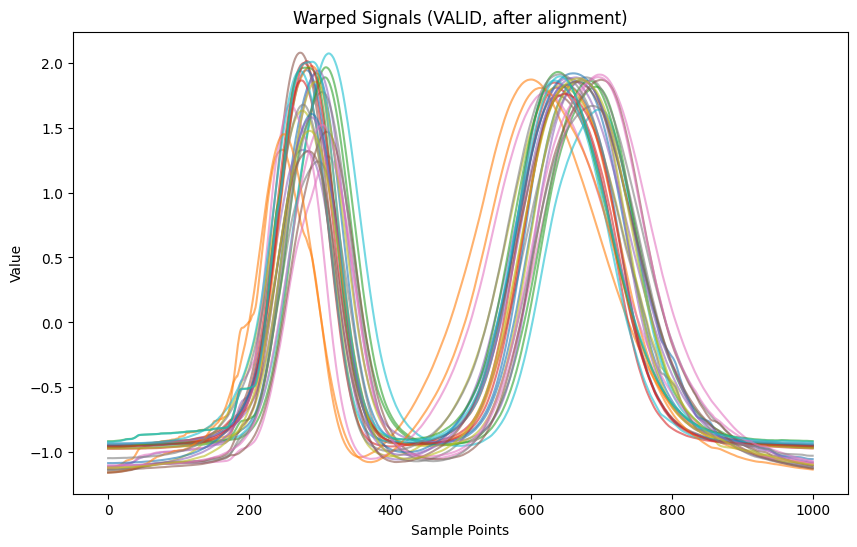

In [ ]:
vae.eval()
all_warped_y_valid = []
all_gamma_valid = []
with torch.no_grad():
    for batch in valid_loader:
        y = batch[0].to(device)
        mu, log_var, gamma_theta, gamma_theta_dot = vae(y)
        warped_y = linear_interp(y, gamma_theta)
        all_warped_y_valid.append(warped_y.cpu())
        all_gamma_valid.append(gamma_theta.cpu())
all_warped_y_valid = torch.cat(all_warped_y_valid, dim=0)
all_gamma_valid = torch.cat(all_gamma_valid, dim=0)

# first 30 valid
plt.figure(figsize=(10,6))
for i in range(30):
    plt.plot(all_warped_y_valid[i].numpy(), alpha=0.6)
plt.title('Warped Signals (VALID, after alignment)')
plt.xlabel('Sample Points')
plt.ylabel('Value')
plt.show()

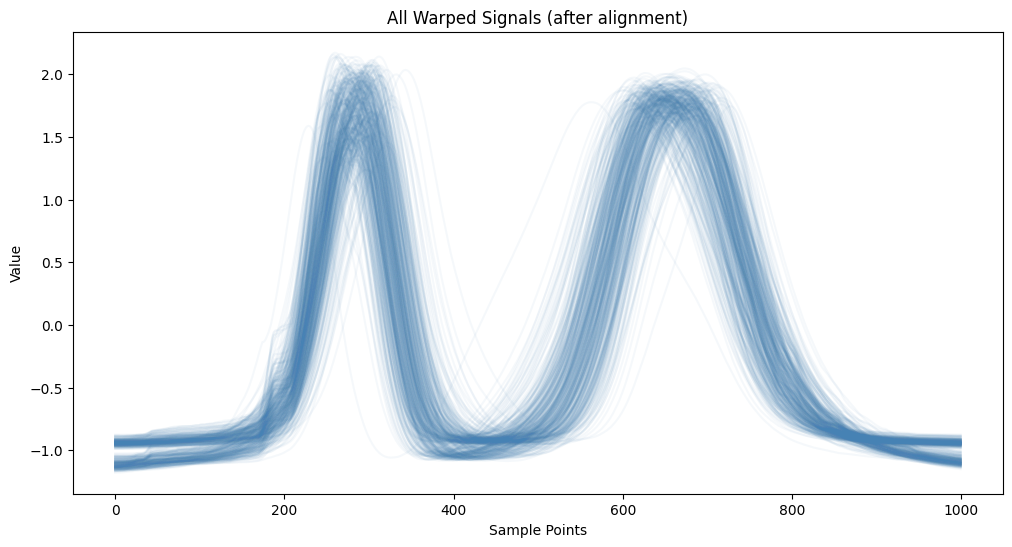

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(all_warped_y_valid.shape[0]):
    plt.plot(all_warped_y_valid[i].numpy(), color='steelblue', alpha=0.05)

plt.title('All Warped Signals (after alignment)')
plt.xlabel('Sample Points')
plt.ylabel('Value')
plt.show()